# Rings Autoencoder

**Goal:** Take the toy "rings" dataset, and train the slot attention autoencoder from Lukas to predict the particle properties.

**Table of Contents:**

1. Load in the data
2. Setup the model
3. Train the autoencoder
4. Look at the results
5. Estimate the energy and position.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Lukas's slot attention code
import os
os.sys.path.append('code')

from model import SlotAttentionEncoder, build_grid
from data import gen_events

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device='cpu'

In [3]:
device

device(type='mps')

In [4]:
isRing=True

## 1. Load in the data

Using [Florian's repo](https://gitlab.lrz.de/neural_network_clustering/permutation_invariant_loss/-/blob/main/test_blur.ipynb) for generating rings.

In [5]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

In [6]:
# bins = [np.linspace(-7,7,41)]*2
# _ed = np.linspace(-7,7,41)
# _ct = _ed[:-1] + np.diff(_ed)/2
# grid = np.meshgrid(*[_ct]*2, indexing='ij')
# # grid[0] are the (x,y) of the y locations
# # grid[1] are the y locations

# K = 2
# centers = np.random.uniform(-6,6, size = (K, 2))
# X = np.concatenate([np.random.multivariate_normal(cc,0.2*np.eye(2), size = (1000,)) for cc in centers])
# c,_,_= np.histogram2d(X[:,0], X[:,1], bins = bins)
# c = np.log(c + 1e-2)
# c = np.stack([grid[0],grid[1],1-grid[0],1-grid[1],c])
# # return 
# # torch.FloatTensor(c)[None,:], torch.FloatTensor(centers)[None,:]

In [8]:
ggrid = build_grid([nPixels,nPixels])
ggrid.shape

(1, 32, 32, 4)

In [9]:
# eventInfos, eventHistograms = gen_events(bins,N_events=1, isRing=isRing, blurImage=False)

# # X, Y = np.meshgrid(bins, bins)

# print(eventHistograms.shape)

# for iEvent, H in enumerate(eventHistograms):
#     print(eventInfos[iEvent])
#     plt.pcolormesh(X, Y, np.log(H[:,:,0]))
#     plt.show()
    
#     plt.pcolormesh(X, Y, H[:,:,0])
#     plt.show()

In [10]:
bs = 128

centers,img_Es = gen_events(bins,N_events=bs, isRing=isRing, blurImage=False,
                            xlow=xlow,xhigh=xhigh,stdlow=stdlow,stdhigh=stdhigh)

In [11]:
img_Es.shape

(128, 32, 32, 1)

In [12]:
img_Es.shape

(128, 32, 32, 1)

In [13]:
tiled_grid = np.tile(ggrid,[bs,1,1,1])
tiled_grid.shape

(128, 32, 32, 4)

In [14]:
def make_batch(batch_size,bins=bins):
    
    # Call Florian's fct
    centers,img_Es = gen_events(bins,N_events=128, isRing=True, blurImage=False)
    
    img_Es = np.log(img_Es+1e-2)
    
    
    # Make the grid
    tiled_grid = np.tile(ggrid,[bs,1,1,1])
    
    # Concatenate them together
    X = torch.FloatTensor(np.concatenate([tiled_grid,img_Es],axis=-1)).to(device)

    # Lukas put the img coord dims last... duplicate this
    X = torch.permute(X,(0,3,1,2))
    
    return X, torch.FloatTensor(centers).to(device)
    

## 2. Setup the model

In [15]:
class AttModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 32

        self.encoder = SlotAttentionEncoder(device=device)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,nPixels*nPixels),
            torch.nn.Unflatten(-1,(nPixels,nPixels))
        )
        

    def forward(self, data):
        Nbatch, *_ = data.shape
        positions,queries = self.encoder(data)
        decoded = self.decoder(positions)
        reco = decoded.sum(dim = 1)        
        return reco,queries,decoded

    
X, Y = make_batch(bs,bins)
model = AttModel().to(device)

positions, queries = model.encoder(X) #[0].shape

out = model(X) #[0].shape



## 3. Train the autoencoder

Code below copied from Lukas's notebook

In [16]:
def plotit(batchidx, model, data, losses):
    
    with torch.no_grad():
        model.eval()
        pred,queries,decoded = model(data)
        encoded_data = model.encoder.encoder(data)
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = model.encoder.dataN(encoded_data)
        
        att,wts = model.encoder.attention_and_weights(queries,encoded_data)
        
        # att: (Nbatch, n_slots, raw_img_dim)
        # wts: (Nbatch, n_slots, raw_img_dim)
        
#         print(wts.sum(dim=-1).max(),'max')
        print('min(w)',wts.min().cpu().numpy(),'max(w)',wts.max().cpu().numpy(),'>>><<')
    
        att = att.reshape(len(att),3,nPixels,nPixels)
        wts = wts.reshape(len(att),3,nPixels,nPixels)
        
        noise = torch.randn(2,model.encoder.k_slots,model.encoder.slot_dim).to(device)
        crap = model.decoder(noise)
        
    # For plotting, need to put them _all_ back on the cpu
    data = data.cpu()
    pred = pred.cpu()
    decoded = decoded.cpu()
    att = att.cpu()
    wts = wts.cpu()
    crap = crap.cpu()
    
    f,axarr = plt.subplots(3,6)
    
    ax = axarr[0,0]
    ax.set_title('Loss')
    ax.plot(losses)
    ax.set_yscale('log')
    ax.axis('off')
    
    ax = axarr[0,1]
    ax.pcolormesh(data[batchidx,-1], vmin = -3, vmax = 3)
    ax.set_title('Data')
    ax.axis('off')
    
    ax = axarr[0,2]
    ax.pcolormesh(pred[batchidx], vmin = -3, vmax = 3)
    ax.set_title('Reco')
    ax.axis('off')
    
    for i in range(3):
        ax = axarr[0,3+i]
        ax.pcolormesh(att[batchidx,i], vmin = 0, vmax = 1)
        ax.set_title(f'Attn {i}')
        ax.axis('off')
            
    for i in range(3):
        ax = axarr[1,3+i]
        ax.pcolormesh(wts[batchidx,i], vmin = 0, vmax = .001)
        ax.set_title(f'Weight {i}')
        ax.axis('off')
        
    # Turn off the axes that we're not drawing
    for i in range(3):
        ax = axarr[1,i]
        ax.axis('off')
        ax = axarr[2,i]
        ax.axis('off')
        
    ax = axarr[1,0]
    ax.set_title(f'Decode rand')
    ax.pcolormesh(crap[batchidx,0])

    ax = axarr[1,2]
    ax.set_title(f'Sum slots')
    ax.pcolormesh(decoded.sum(dim=1)[batchidx], vmin = -3, vmax = 3)
    for i in range(3):
        ax = axarr[2,3+i]
        ax.pcolormesh(decoded[batchidx,i], vmin = -3, vmax = 3)
        ax.set_title(f'Slot {i}')
        ax.axis('off')
    f.set_size_inches(12,6)
    plt.show()    


In [17]:
bs

128

In [23]:
def train(model, Ntrain = 5000):
    
    # Learning rate schedule config
    learning_rate = 3e-4
    warmup_steps = 5_000
    decay_steps=50_000
    decay_rate = 0.5
    
    opt = torch.optim.Adam(model.parameters(), learning_rate)
    model.train()
    losses = []
    
    # Q -- can I overfit?
#     data, trgt = make_batch(4)
        
    for i in range(Ntrain):
    
#         if i < warmup_steps:
#             learning_rate *= (i / warmup_steps)
#         learning_rate *= np.power(decay_rate, i / decay_steps)
        
        opt.param_groups[0]['lr'] = learning_rate

        data, trgt = make_batch(4)
        pred,*_ = model(data)
        loss = torch.nn.functional.mse_loss(
            data[:,-1,...],
            pred
        )
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        if i % 250 == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            plotit(0,model,data,losses)
#             plotit(1,model,data,losses)

    model.eval()
    return model,losses

In [24]:
bs

128

In [25]:
model = model.to(device)

iter 0 , loss 20.727732 , lr 0.0003
min(w) 1e-08 max(w) 0.20276292 >>><<


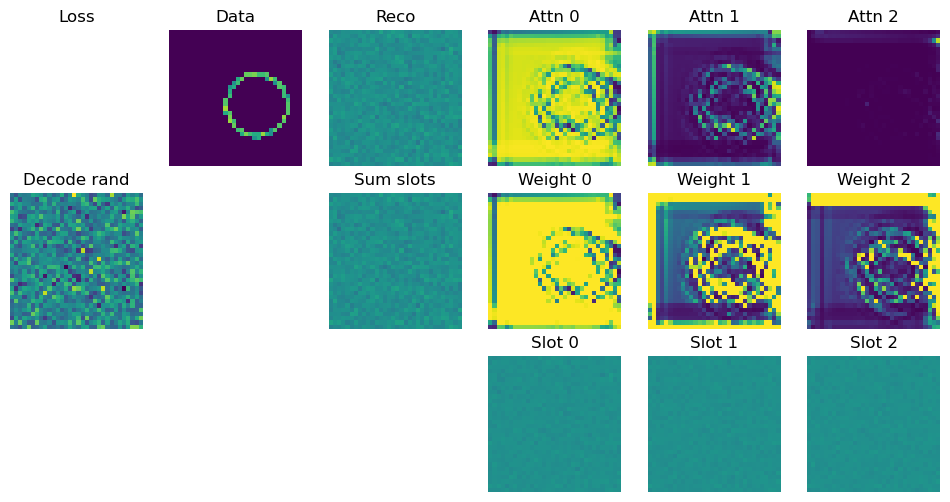

iter 250 , loss 1.440268 , lr 0.0003
min(w) 1e-08 max(w) 0.9460225 >>><<


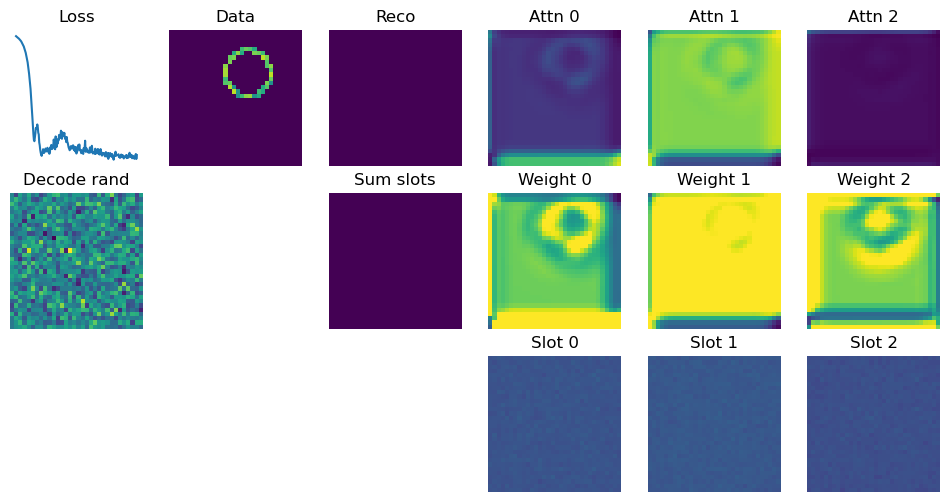

iter 500 , loss 1.8755865 , lr 0.0003
min(w) 1e-08 max(w) 1.0 >>><<


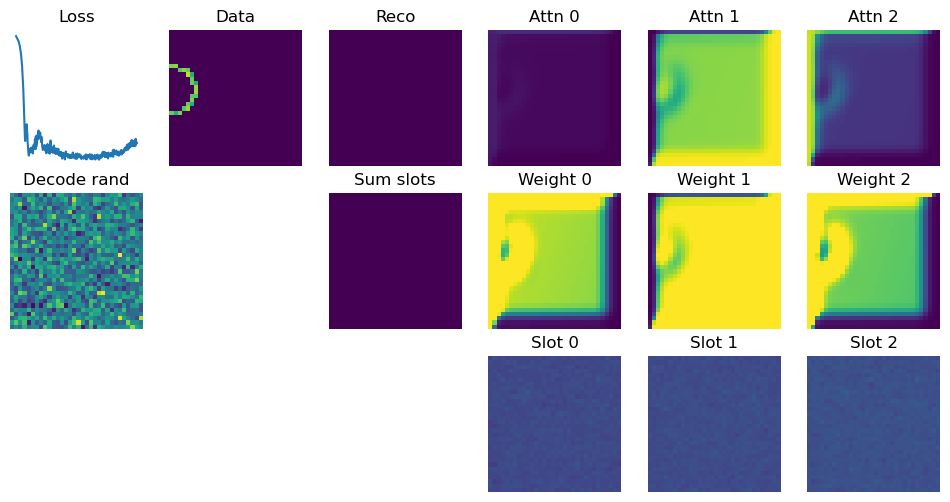

iter 750 , loss 5.364391 , lr 0.0003
min(w) 1e-08 max(w) 1.0 >>><<


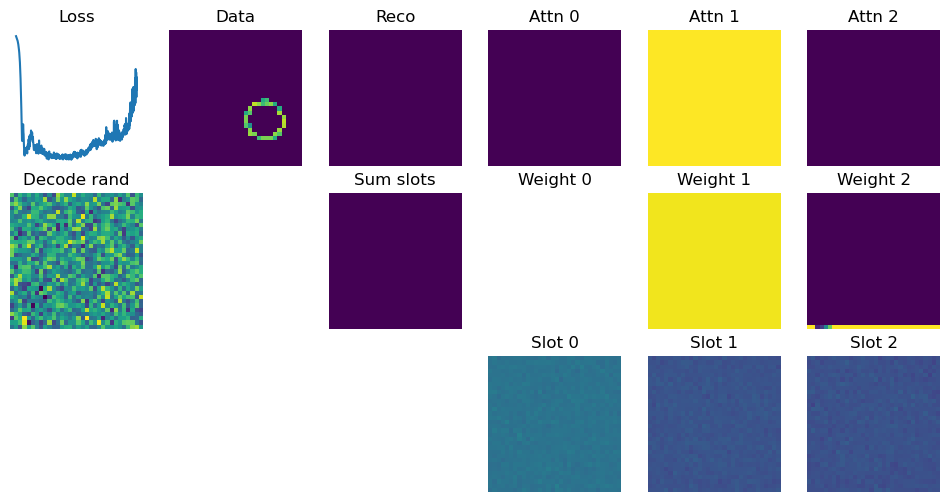

KeyboardInterrupt: 

In [26]:
model = AttModel().to(device)
model,*_rest = train(model,40_000)